# Classification d’entité médicales à partir du langage naturel

**Membres de Groupe :** 

*   HILMI El Mehdi
*   MOURABIT Nisrine
- CHKOUNDA Hajar
- ELAMRANI Soumaya
- MERBOUH Hajar 

/AMSD



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
import tensorflow.keras as k
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns

##models

from tensorflow.keras.layers import (
    Input,
    LSTM,
    GRU,
    Dense,
    Concatenate,
    TimeDistributed,
    Bidirectional,
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer

from nltk.corpus import stopwords

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Exercice 1

In [ ]:
train=pd.read_csv('/content/train.csv')
val=pd.read_csv('/content/val.csv')
test=pd.read_csv('/content/test.csv')

In [ ]:
train

,RawText,ICD10
0,Thrombose veineuse profonde cuisse gauche,I802
1,Hémiplégie post-traumatique,S099
2,Masculinisation avec hyperplasie surrénale,E250
3,Hyperammoniémie cérébrale,E722
4,Fistule artérioveineuse congénitale périphériq...,Q257
...,...,...
79360,Ulcère rectosigmoïdien,K633
79361,Rupture membranes ancienne,P011
79362,Double hernie discale D9/D10-D10/D11,M512
79363,Péritonite chimique,T816


In [ ]:
# Remplacez "df" par votre DataFrame
corpus = train[["RawText"]]
# combiner tous les textes dans la colonne "corpus"
combined_corpus = " ".join(corpus['RawText'])
print(combined_corpus)

In [ ]:
from nltk.probability import FreqDist

words = nltk.word_tokenize(combined_corpus)

# Création d'un dictionnaire de fréquences de mots
fdist = FreqDist(words)

# Compter le nombre de mots différents
num_unique_words = len(fdist)
print("Nombre de mots différents dans le corpus:", num_unique_words)

Nombre de mots différents dans le corpus: 23363


In [ ]:
cim_df = train["ICD10"].unique()
cim_df

array(['I802', 'S099', 'E250', ..., 'M992', 'W94', 'R'], dtype=object)

In [ ]:
cim_df = cim_df.tolist()
del cim_df[-1]
len(cim_df)

8171

In [ ]:
train['ICD10'].value_counts()

S062    505
C798    424
C859    357
C349    334
Z924    312
       ... 
M83       1
M184      1
S463      1
Q324      1
R         1
Name: ICD10, Length: 8172, dtype: int64

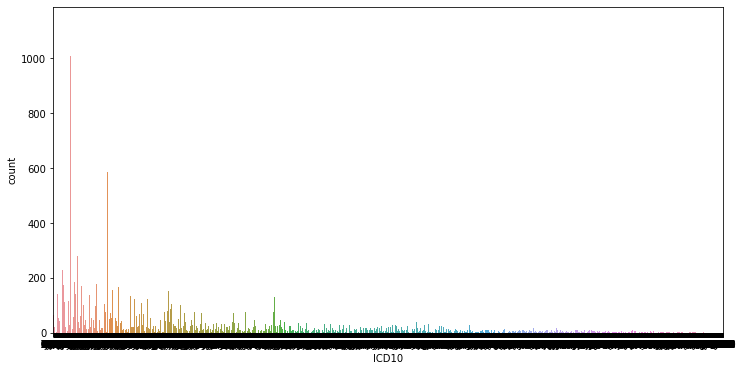

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.countplot(x='ICD10',data=train)

### EDA

In [ ]:
train.head()

,RawText,ICD10
0,Thrombose veineuse profonde cuisse gauche,I802
1,Hémiplégie post-traumatique,S099
2,Masculinisation avec hyperplasie surrénale,E250
3,Hyperammoniémie cérébrale,E722
4,Fistule artérioveineuse congénitale périphériq...,Q257


In [ ]:
train.describe()

,RawText,ICD10
count,79365,79365
unique,75550,8172
top,Traumatisme voir aussi le type précisé de trau...,S062
freq,28,505


In [ ]:
temp = train.groupby('ICD10').count()['RawText'].reset_index().sort_values(by='RawText',ascending=False)
temp.head(10).style.background_gradient(cmap='Purples')

,ICD10,RawText
6315,S062,505
1004,C798,424
1044,C859,357
796,C349,334
8118,Z924,312
2813,I251,278
5956,Q878,257
3034,I743,252
8116,Z922,249
8145,Z958,245


In [ ]:
#Let's draw a Funnel-Chart for better visualization
from plotly import graph_objs as go
fig = go.Figure(go.Funnelarea(
    text =temp.head(20).ICD10,
    values = temp.head(20).RawText,
    title = {"position": "top center", "text": "Funnel-Chart of the 20 most frequent ICD10 Distribution"}
    ))
fig.show()

In [ ]:
train_vis=train.copy()
train_vis['Num_word_text'] = train_vis['RawText'].apply(lambda x:len(str(x).split())) #Number Of words in raw text
train_vis.head()

,RawText,ICD10,Num_word_text
0,Thrombose veineuse profonde cuisse gauche,I802,5
1,Hémiplégie post-traumatique,S099,2
2,Masculinisation avec hyperplasie surrénale,E250,4
3,Hyperammoniémie cérébrale,E722,2
4,Fistule artérioveineuse congénitale périphériq...,Q257,6


In [ ]:
import plotly.figure_factory as ff
hist_data = [train_vis['Num_word_text']]

group_labels = ['RawText']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words in Raw Text')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

The number of words plot is really interesting ,the texts having number of words greater than 13 are very less and thus the number of words distribution plot is right skewed

Let's also look at the most common words in Text : This will give us an idea about stop words : are they disturbing our analysis ?

In [ ]:
from collections import Counter

train_vis['temp_list'] = train_vis['RawText'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,de,4827
1,aussi,3669
2,voir,3417
3,gauche,3280
4,NCA,2826
5,à,2685
6,avec,2405
7,Syndrome,2002
8,-,1999
9,droit,1731


In [ ]:
import plotly.express as px
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Raw text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('french')]
train_vis['temp_list'] = train_vis['temp_list'].apply(lambda x:remove_stopword(x))

In [ ]:
top = Counter([item for sublist in train_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,voir,3417
2,gauche,3280
3,NCA,2826
4,Syndrome,2002
5,-,1999
6,droit,1731
7,type,1619
8,Maladie,1515
9,Tumeur,1499
10,droite,1492


As we've seen before, our target label ICD10 contains many labels which makes it a bit difficult for us to get clear visualisations. Thus, we've decided to create a new feature which will contain the first letter of each label in ICD10. That way our visualisations will become more clear and easier to be analyzed.

In [ ]:
train_vis['label']=train_vis.ICD10.str.slice(0,1)

In [ ]:
train_vis.head()

,RawText,ICD10,Num_word_text,temp_list,label
0,Thrombose veineuse profonde cuisse gauche,I802,5,"[Thrombose, veineuse, profonde, cuisse, gauche]",I
1,Hémiplégie post-traumatique,S099,2,"[Hémiplégie, post-traumatique]",S
2,Masculinisation avec hyperplasie surrénale,E250,4,"[Masculinisation, hyperplasie, surrénale]",E
3,Hyperammoniémie cérébrale,E722,2,"[Hyperammoniémie, cérébrale]",E
4,Fistule artérioveineuse congénitale périphériq...,Q257,6,"[Fistule, artérioveineuse, congénitale, périph...",Q


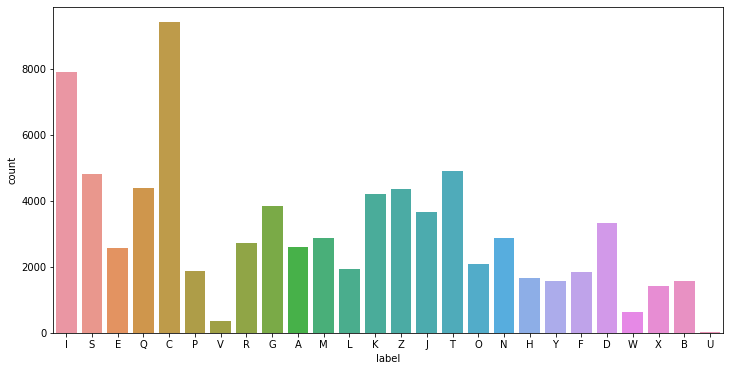

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='label',data=train_vis)

In [ ]:
temp = train_vis.groupby('label').count()['RawText'].reset_index().sort_values(by='RawText',ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,RawText
2,C,9405
8,I,7895
19,T,4911
18,S,4793
16,Q,4379
25,Z,4363
10,K,4208
6,G,3844
9,J,3672
3,D,3332


In [ ]:
#Let's draw a Funnel-Chart for better visualization
from plotly import graph_objs as go
fig = go.Figure(go.Funnelarea(
    text =temp.label,
    values = temp.RawText,
    title = {"position": "top center", "text": "Funnel-Chart of the 20 most frequent ICD10 Distribution"}
    ))
fig.show()

let's plot the most common words for C , I and T labels since they are the most frequents ones. To get an idea about their nature, same process could be applied on all the labels.

In [ ]:
C_icd = train_vis[train_vis['label']=='C']
I_icd = train_vis[train_vis['label']=='I']
T_icd = train_vis[train_vis['label']=='T']

**Label C**

In [ ]:
from _plotly_utils.utils import template_doc
#MosT common words according to C label
top = Counter([item for sublist in C_icd['temp_list'] for item in sublist])
temp_C = pd.DataFrame(top.most_common(20))
temp_C.columns = ['Common_words for C label','count']
temp_C.style.background_gradient(cmap='Greens')

,Common_words for C label,count
0,Cancer,1273
1,Carcinome,1111
2,gauche,947
3,Lymphome,701
4,droit,646
5,Tumeur,627
6,cellules,468
7,épidermoïde,383
8,Néoplasie,349
9,Sarcome,344


In [ ]:
fig = px.treemap(temp_C, path=['Common_words for C label'], values='count',title='Tree Of Most Common Words in C label')
fig.show()

**Label I**

In [ ]:
#MosT common words according to I label
top = Counter([item for sublist in I_icd['temp_list'] for item in sublist])
temp_I = pd.DataFrame(top.most_common(20))
temp_I.columns = ['Common_words for I label','count']
temp_I.style.background_gradient(cmap='Reds')

,Common_words for I label,count
0,Thrombose,532
1,gauche,497
2,artère,394
3,cardiaque,348
4,aortique,256
5,aiguë,253
6,droite,246
7,aussi,239
8,Ischémie,238
9,artérielle,237


In [ ]:
fig = px.treemap(temp_I, path=['Common_words for I label'], values='count',title='Tree Of Most Common Words in I label')
fig.show()

**Label T**

In [ ]:
#MosT common words according to T label
top = Counter([item for sublist in T_icd['temp_list'] for item in sublist])
temp_T = pd.DataFrame(top.most_common(20))
temp_T.columns = ['Common_words for T label','count']
temp_T.style.background_gradient(cmap='Blues')

,Common_words for T label,count
0,NCA,332
1,Brûlure,269
2,Complications,264
3,due,208
4,greffe,207
5,prothèse,207
6,Séquelles,200
7,post-opératoire,196
8,Infection,176
9,membre,156


In [ ]:
fig = px.treemap(temp_T, path=['Common_words for T label'], values='count',title='Tree Of Most Common Words in T label')
fig.show()

Let's Look at Unique Words

In [ ]:
raw_text = [word for word_list in train_vis['temp_list'] for word in word_list]

In [ ]:
def words_unique(label,numwords,raw_words):
    '''
    Input:
        label- label category (ex. 'C');
        numwords - how many specific words do we want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in 
        the chosen label (in descending order based on their counts)..

    '''
    allother = []
    for item in train_vis[train_vis.label != label]['temp_list']:
        for word in item:
            allother.append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train_vis[train_vis.label== label]['temp_list']:
       for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

**C label**

In [ ]:
Unique_C= words_unique('C', 20, raw_text)
print("The top 20 unique words in C label are:")
Unique_C.style.background_gradient(cmap='Greens')

The top 20 unique words in C label are:


,words,count
0,Métastase,293
1,différencié,129
2,Glioblastome,116
3,neuro-endocrine,116
4,Léiomyosarcome,74
5,Néoplasme,61
6,Oligodendrogliome,59
7,Ostéosarcome,58
8,Myélome,56
9,carcinomateuse,56


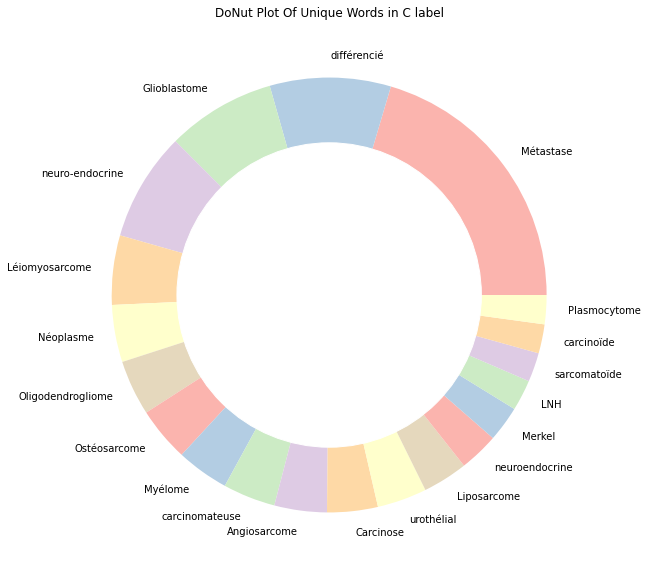

In [ ]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_C['count'], labels=Unique_C.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Words in C label')
plt.show()

**I label**

In [ ]:
Unique_I= words_unique('I', 20, raw_text)
print("The top 20 unique words in I label are:")
Unique_I.style.background_gradient(cmap='Reds')

The top 20 unique words in I label are:


,words,count
0,A52.0,89
1,athéromateuse,39
2,variqueux,34
3,Athéromatose,33
4,sous-endocardique,32
5,artéritique,25
6,VG,24
7,surale,21
8,rythmique,19
9,B33.2,19


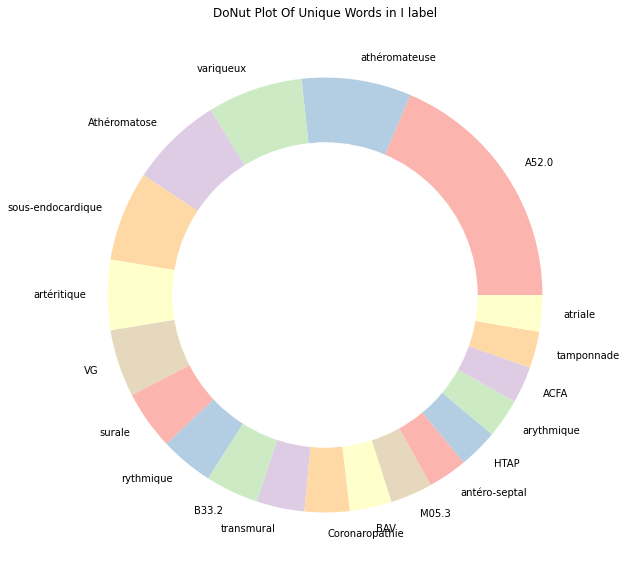

In [ ]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_I['count'], labels=Unique_I.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Words in I label')
plt.show()

**T label**

In [ ]:
Unique_T= words_unique('T', 20, raw_text)
print("The top 20 unique words in T label are:")
Unique_T.style.background_gradient(cmap='Blues')

The top 20 unique words in T label are:


,words,count
0,"infection,",47
1,électronique,45
2,Corrosion,35
3,greffon,31
4,Rejet,26
5,électricité,23
6,erreur,23
7,Gelure,22
8,"Complications,",21
9,cent,20


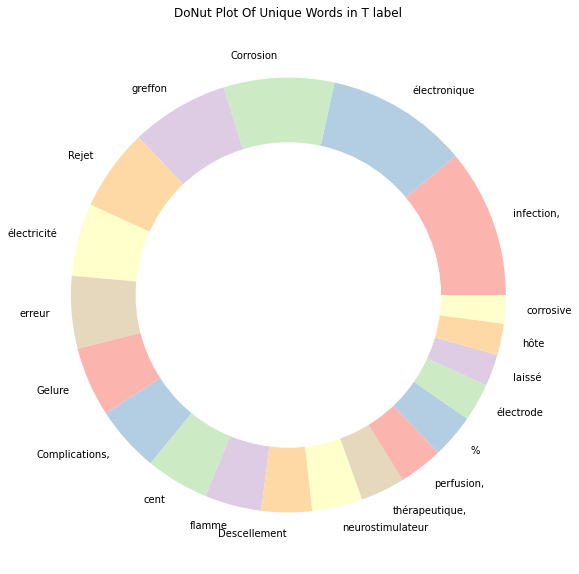

In [ ]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_T['count'], labels=Unique_T.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Words in T label')
plt.show()

By Looking at the Unique Words of the most three frequent labels, we now have much more clarity about the data,these unique words are very strong determiners of our target labels

**It's Time For WordClouds**

We Have already visualized our Most Common words, but Wordclouds Provide us much more clarity !

We will be building wordclouds in the following order:

WordCloud of C-labels

WordCloud of I-labels

WordCloud of T-labels

In [ ]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopword = set(stopwords.words('french'))
    more_stopwords = {'voir', "aussi"}
    stopword = stopword.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopword,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

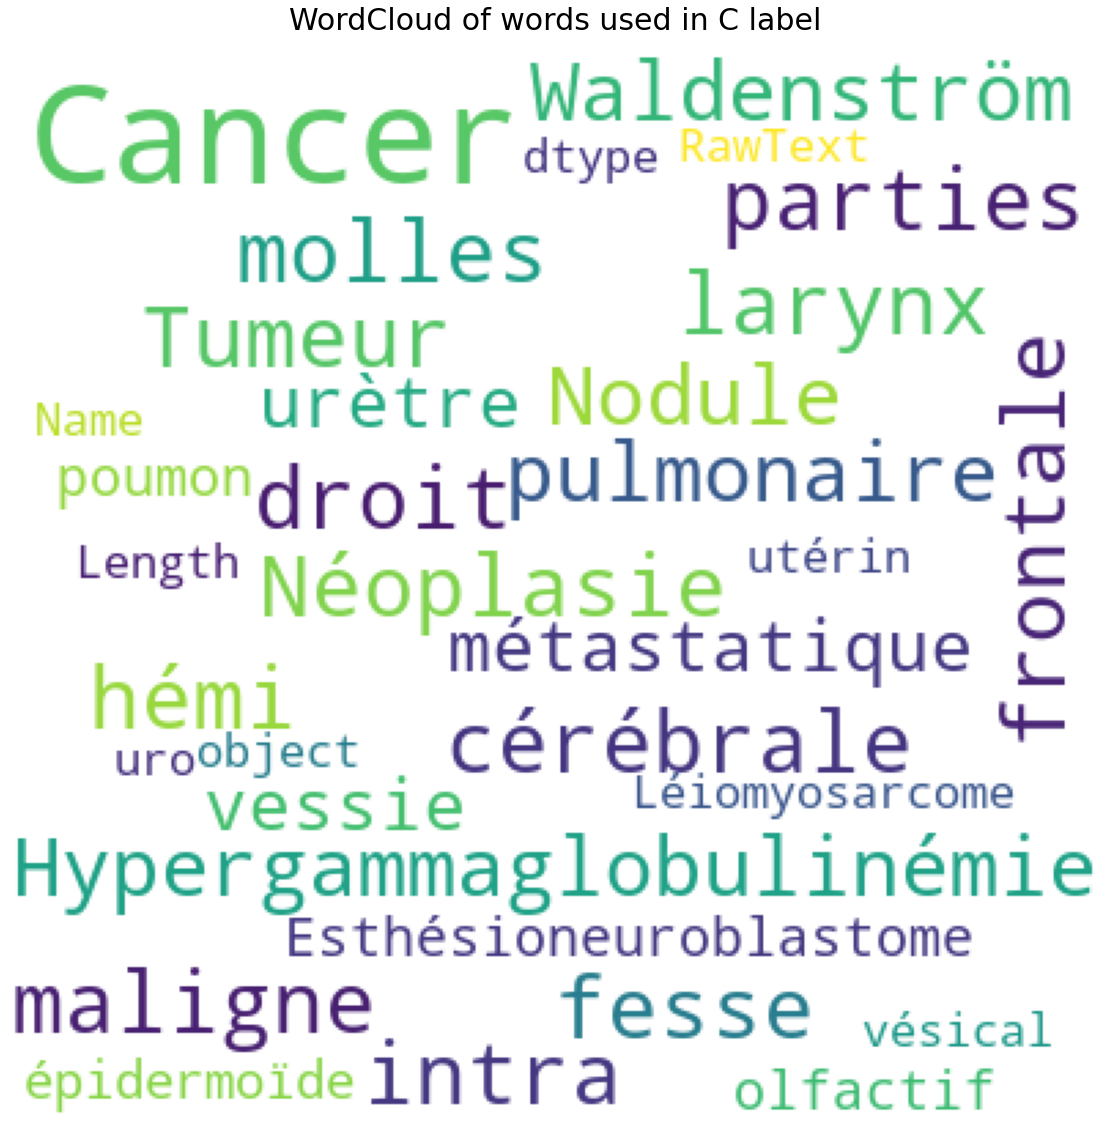

In [ ]:
plot_wordcloud(C_icd.RawText,color='white',max_font_size=50,title_size=30,title="WordCloud of words used in C label")

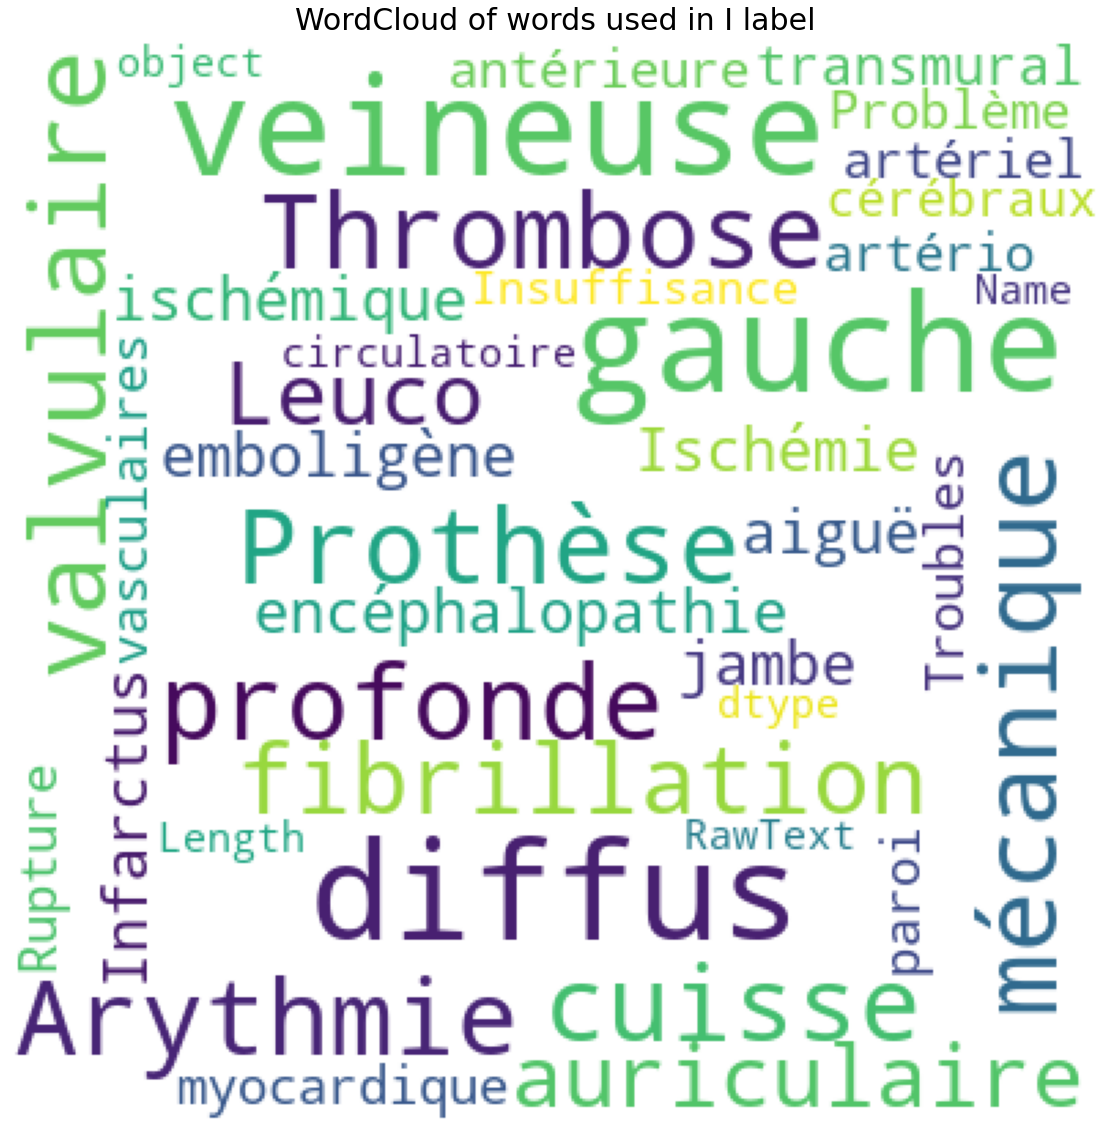

In [ ]:
plot_wordcloud(I_icd.RawText,color='white',max_font_size=50,title_size=30,title="WordCloud of words used in I label")

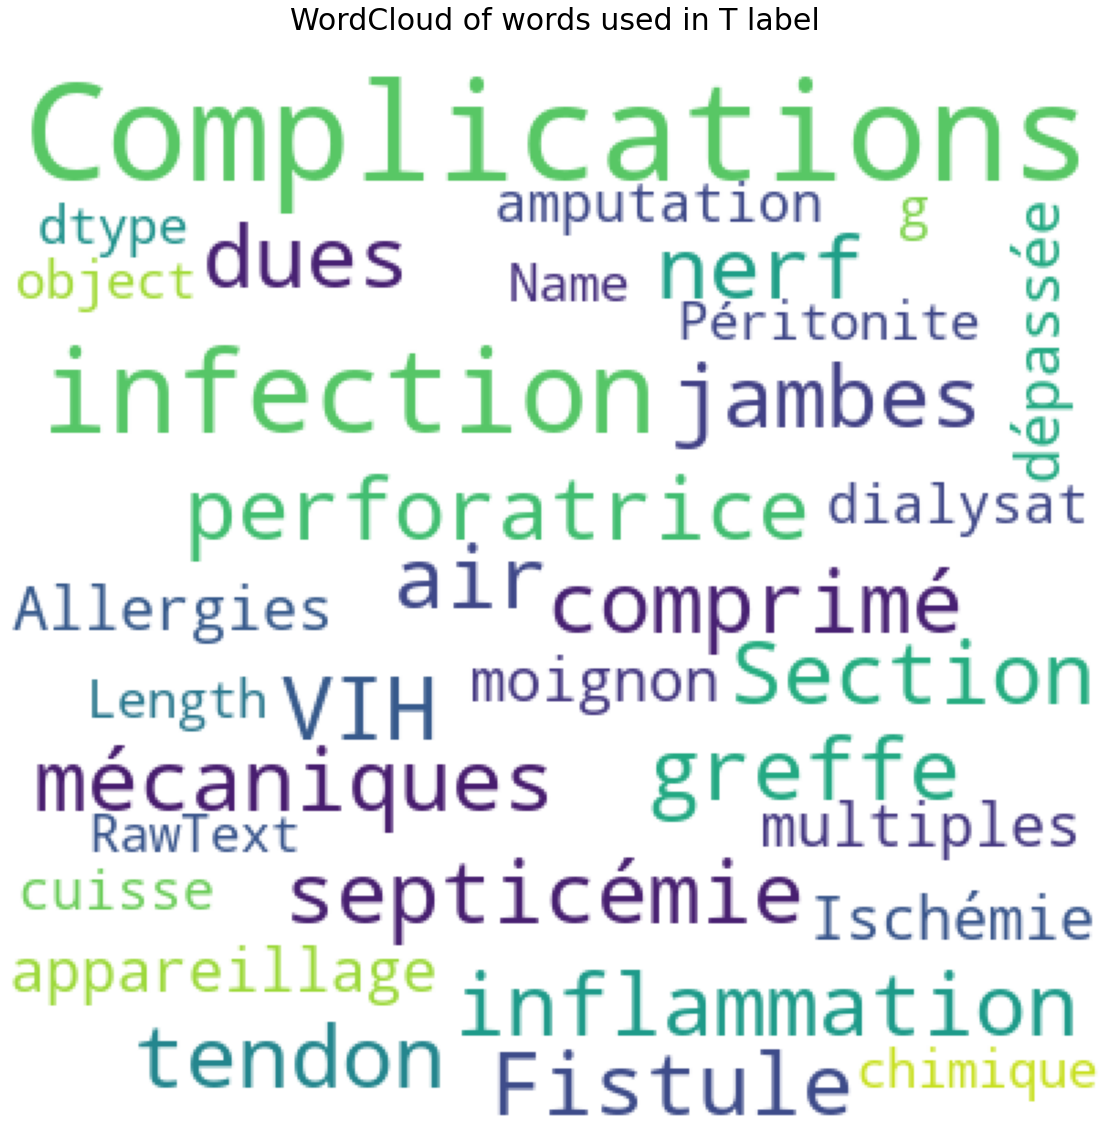

In [ ]:
plot_wordcloud(T_icd.RawText,color='white',max_font_size=50,title_size=30,title="WordCloud of words used in T label")

# Exercice 2 

Classification du premier caractère du code CIM-10 à partir du langage naturel

### Methode 1 (vue en classe)

In [ ]:
train.head()

,RawText,ICD10
0,Thrombose veineuse profonde cuisse gauche,I802
1,Hémiplégie post-traumatique,S099
2,Masculinisation avec hyperplasie surrénale,E250
3,Hyperammoniémie cérébrale,E722
4,Fistule artérioveineuse congénitale périphériq...,Q257


In [ ]:
MAX_VOCAB=10000
HIDDEN_DIM=32

In [ ]:
#change for part II
train['label']=train.ICD10.str.slice(0,1)
val['label']=val.ICD10.str.slice(0,1)
test['label']=test.ICD10.str.slice(0,1)

In [ ]:
#label encoder to convert first letters 
label_encoder=LabelEncoder()
#change for all (np.concat(train,test,val))
label_encoder.fit(train['label'])

LabelEncoder()

In [ ]:
train.label = label_encoder.transform(train.label)
##repeat same operation for test and val
val.label = label_encoder.transform(val.label)
test.label = label_encoder.transform(test.label)

In [ ]:
#first layer for rnn -> couche de vectorisation
text_vec=k.layers.TextVectorization(max_tokens=MAX_VOCAB)

In [ ]:
# adapt the layer to our train data
text_vec.adapt(train.RawText)

In [ ]:
#construction rapide de graphe de couches (L1, L2, ....) -> sequentiel takes a list of layers
#steps : 1-couche de vectorisation 2-embeddings 3- Layers LSTM 4- Dense Layer with 26 state and activation softmax
model=k.Sequential([k.layers.Input(shape=[], dtype=tf.string),
                    text_vec,
                    k.layers.Embedding(input_dim=MAX_VOCAB,
                                       output_dim=HIDDEN_DIM,
                                       mask_zero=True,
                                       ),
                    k.layers.LSTM(units=HIDDEN_DIM,
                                  dropout=.1),
                    #change for part II 26 -> len(label_encoder.classes_)
                    k.layers.Dense(26, activation='softmax')]
                   )
 

In [ ]:
# compile model w adam optimizer and sparse_softmax_crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#fitting the model
model.fit(x=train.RawText,
          y=train.label,
          validation_data=(val.RawText, val.label),
          epochs=10)

Epoch 1/10
5681/5681 [==============================] - 46s 7ms/step - loss: 1.2574 - accuracy: 0.6555 - val_loss: 0.7871 - val_accuracy: 0.7779
Epoch 2/10
5681/5681 [==============================] - 40s 7ms/step - loss: 0.6966 - accuracy: 0.7972 - val_loss: 0.6817 - val_accuracy: 0.7993
Epoch 3/10
5681/5681 [==============================] - 42s 7ms/step - loss: 0.6039 - accuracy: 0.8153 - val_loss: 0.6412 - val_accuracy: 0.8078
Epoch 4/10
5681/5681 [==============================] - 40s 7ms/step - loss: 0.5568 - accuracy: 0.8261 - val_loss: 0.6211 - val_accuracy: 0.8091
Epoch 5/10
5681/5681 [==============================] - 40s 7ms/step - loss: 0.5250 - accuracy: 0.8331 - val_loss: 0.6090 - val_accuracy: 0.8122
Epoch 6/10
5681/5681 [==============================] - 40s 7ms/step - loss: 0.5013 - accuracy: 0.8384 - val_loss: 0.6020 - val_accuracy: 0.8154
Epoch 7/10
5681/5681 [==============================] - 40s 7ms/step - loss: 0.4836 - accuracy: 0.8424 - val_loss: 0.6034 - val_ac

### Methode 2

In [ ]:
data=train.copy()
data = data.dropna(axis=0)

In [ ]:
data.head()

,RawText,ICD10
0,Thrombose veineuse profonde cuisse gauche,I
1,Hémiplégie post-traumatique,S
2,Masculinisation avec hyperplasie surrénale,E
3,Hyperammoniémie cérébrale,E
4,Fistule artérioveineuse congénitale périphériq...,Q
...,...,...
26473,Ischémie lobes occipitaux,I
26474,Infection pulmonaire traînante,J
26475,Nécrose noyaux gris centraux,P
26476,"Hypertonie, hypertonicité congénitale",P


In [ ]:
data['label'].value_counts()

C    3140
I    2591
S    1650
T    1611
Q    1507
Z    1409
K    1389
G    1300
J    1220
D    1094
N     977
R     941
M     931
A     861
E     856
O     726
L     668
P     614
F     612
H     559
Y     518
B     499
X     478
W     210
V     108
U       9
Name: ICD10, dtype: int64

In [ ]:
data['label'].value_counts().shape

(26,)

#### Préparation des données 

In [ ]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Charger les données
texts = data['RawText'].tolist()

# Nettoyer les données
texts = [text.lower() for text in texts] # mettre tous les caractères en minuscule
texts = [text.replace("[^a-z]", " ") for text in texts] # enlever les caractères indésirables

In [ ]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Conversion en nombres
vocab_size = len(tokenizer.word_index) + 1

# Padder les séquences
maxlen = 6
x_train = pad_sequences(sequences, maxlen=maxlen,padding='post', truncating='post')

In [ ]:
x_train

array([[   39,   238,   324,   223,     4,     0],
       [  589,    15,    85,     0,     0,     0],
       [ 5947,     7,  1173,   869,     0,     0],
       ...,
       [   81,  1427,  1676,  1436,     0,     0],
       [ 3473,  4353,    28,     0,     0,     0],
       [11057,   762,     0,     0,     0,     0]], dtype=int32)

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


# Create label encoder
label_encoder = LabelEncoder()

# Encode text labels to integers
data['label'] = label_encoder.fit_transform(data['ICD10'])

# Number of classes
num_classes = len(label_encoder.classes_)

# Convert labels to one-hot encoding
one_hot_labels = np.eye(num_classes)[data['label']]

print(one_hot_labels)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<ipython-input-178-930fd59279d9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = label_encoder.fit_transform(data['ICD10'])


Model

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout

# Définir le modèle CNN
model = Sequential()
model.add(Embedding(26478, 128, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(26, activation='softmax'))

# Compiler le modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraîner le modèle
model.fit(x_train, one_hot_labels, batch_size=32, epochs=10)


Epoch 1/10
828/828 [==============================] - 30s 36ms/step - loss: 1.9413 - accuracy: 0.4623
Epoch 2/10
828/828 [==============================] - 30s 37ms/step - loss: 0.8743 - accuracy: 0.7597
Epoch 3/10
828/828 [==============================] - 30s 36ms/step - loss: 0.4993 - accuracy: 0.8572
Epoch 4/10
828/828 [==============================] - 30s 36ms/step - loss: 0.3488 - accuracy: 0.8951
Epoch 5/10
828/828 [==============================] - 30s 36ms/step - loss: 0.2740 - accuracy: 0.9156
Epoch 6/10
828/828 [==============================] - 30s 36ms/step - loss: 0.2313 - accuracy: 0.9271
Epoch 7/10
828/828 [==============================] - 30s 36ms/step - loss: 0.2015 - accuracy: 0.9341
Epoch 8/10
828/828 [==============================] - 30s 36ms/step - loss: 0.1831 - accuracy: 0.9386
Epoch 9/10
828/828 [==============================] - 30s 36ms/step - loss: 0.1605 - accuracy: 0.9447
Epoch 10/10
828/828 [==============================] - 30s 36ms/step - loss: 0.153

# Exercice 3

**Objectif :** Classification du code CIM-10 entier à partir du langage naturel.



### Méthode :

La 1ere methode ne va pas drastiquement changer entre cette
partie et la précédente :

- Changing the number of units to the number of new classes : len(label_encoder.classes_)

- We will add a 1D convolutional, that scans the text to extract local features, and a bidirectional layer, that captures long-term dependencies in the text, to the previous code, we can insert them in the sequential stack of layers before the LSTM layer.

- We will try to increase the depth of our model, we can add additional LSTM layers. One way to do this is to set the ***return_sequences*** parameter of the first LSTM layer to True, which will allow the next LSTM layer to receive the full sequence of outputs from the first LSTM layer as input. We can also add an additional LSTM layer after the first one.

In [ ]:
MAX_VOCAB=10000
HIDDEN_DIM=32

In [ ]:
#label encoder to convert first letters 
label_encoder=LabelEncoder()
#change for all (np.concat(train,test,val))
label_encoder.fit(train['ICD10'])

LabelEncoder()

Test and val contain previously unseen labels

In [ ]:
for i in range(val.shape[0]):
  if val['ICD10'][i] not in labels :
    train = train.append({'RawText': val['RawText'][i], 'ICD10':val['ICD10'][i]}, ignore_index=True)
    val=val.drop(i)
    labels=train['ICD10'].tolist()
for i in range(test.shape[0]):
  if test['ICD10'][i] not in labels :
    train = train.append({'RawText': test['RawText'][i], 'ICD10':test['ICD10'][i]}, ignore_index=True)
    test=test.drop(i)
    labels=train['ICD10'].tolist()
val=val.reset_index()
test=test.reset_index()

In [ ]:
val=val[['RawText','ICD10']]
test=test[['RawText','ICD10']]

In [ ]:
train.ICD10 = label_encoder.transform(train.ICD10)
##repeat same operation for test and val
val.ICD10 = label_encoder.transform(val.ICD10)
test.ICD10 = label_encoder.transform(test.ICD10)

In [ ]:
#first layer for rnn -> couche de vectorisation
text_vec=k.layers.TextVectorization(max_tokens=MAX_VOCAB)

In [ ]:
# adapt the layer to our train data
text_vec.adapt(train.RawText)

In [ ]:
#Here, Conv1D layer is added with 32 filters, kernel_size of 3, padding set to 'same' and activation function set to 'relu'.
#Bidirectional layer is added with LSTM layer as an argument. 
#This will make the LSTM layer bidirectional, processing the input sequence in both forward and backward directions.
model = k.Sequential([k.layers.Input(shape=[], dtype=tf.string),
                      text_vec,
                      k.layers.Embedding(input_dim=MAX_VOCAB,
                                         output_dim=HIDDEN_DIM,
                                         mask_zero=True,
                                         ),
                      k.layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
                      k.layers.Bidirectional(k.layers.LSTM(units=HIDDEN_DIM, dropout=0.1, return_sequences=True)),
                      k.layers.Bidirectional(k.layers.LSTM(units=HIDDEN_DIM, dropout=0.1)),
                      #k.layers.Flatten(),
                      k.layers.Dense(len(label_encoder.classes_), activation='softmax')]
                     )


In [ ]:
# compile model w adam optimizer and sparse_softmax_crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#fitting the model
model.fit(x=train.RawText,
          y=train.ICD10,
          validation_data=(val.RawText, val.ICD10),
          epochs=50)

Epoch 1/50
5681/5681 [==============================] - 87s 14ms/step - loss: 7.4447 - accuracy: 0.0251 - val_loss: 6.4738 - val_accuracy: 0.0637
Epoch 2/50
5681/5681 [==============================] - 80s 14ms/step - loss: 5.7728 - accuracy: 0.1113 - val_loss: 5.2220 - val_accuracy: 0.1618
Epoch 3/50
5681/5681 [==============================] - 81s 14ms/step - loss: 4.7603 - accuracy: 0.1959 - val_loss: 4.5049 - val_accuracy: 0.2332
Epoch 4/50
5681/5681 [==============================] - 86s 15ms/step - loss: 4.1041 - accuracy: 0.2624 - val_loss: 4.0253 - val_accuracy: 0.2914
Epoch 5/50
5681/5681 [==============================] - 81s 14ms/step - loss: 3.6410 - accuracy: 0.3195 - val_loss: 3.6670 - val_accuracy: 0.3398
Epoch 6/50
5681/5681 [==============================] - 81s 14ms/step - loss: 3.2918 - accuracy: 0.3641 - val_loss: 3.4324 - val_accuracy: 0.3670
Epoch 7/50
5681/5681 [==============================] - 83s 15ms/step - loss: 3.0287 - accuracy: 0.4016 - val_loss: 3.2369 -

### Premiers caractères

Il est assez courant dans la littérature académique sur le sujet, de ne pas rapporter seulement les métriques à l’échelle de la correspondance entre valeur vraie et prédiction du code en entier, mais de s’intéresser aussi aux premiers caractères.



In [ ]:
train=pd.read_csv('/content/train.csv')
val=pd.read_csv('/content/val.csv')
test=pd.read_csv('/content/test.csv')

#### Se limiter au 1er caractère

In [ ]:
MAX_VOCAB=10000
HIDDEN_DIM=32

In [ ]:
#change for part II
train['label']=train.ICD10.str.slice(0,1)
val['label']=val.ICD10.str.slice(0,1)
test['label']=test.ICD10.str.slice(0,1)

In [ ]:
#label encoder to convert first letters 
label_encoder=LabelEncoder()
#change for all (np.concat(train,test,val))
label_encoder.fit(train['label'])

LabelEncoder()

In [ ]:
train.label = label_encoder.transform(train.label)
##repeat same operation for test and val
val.label = label_encoder.transform(val.label)
test.label = label_encoder.transform(test.label)

In [ ]:
#first layer for rnn -> couche de vectorisation
text_vec=k.layers.TextVectorization(max_tokens=MAX_VOCAB)

In [ ]:
# adapt the layer to our train data
text_vec.adapt(train.RawText)

In [ ]:
#Here, Conv1D layer is added with 32 filters, kernel_size of 3, padding set to 'same' and activation function set to 'relu'.
#Bidirectional layer is added with LSTM layer as an argument. 
#This will make the LSTM layer bidirectional, processing the input sequence in both forward and backward directions.
model = k.Sequential([k.layers.Input(shape=[], dtype=tf.string),
                      text_vec,
                      k.layers.Embedding(input_dim=MAX_VOCAB,
                                         output_dim=HIDDEN_DIM,
                                         mask_zero=True,
                                         ),
                      k.layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
                      k.layers.Bidirectional(k.layers.LSTM(units=HIDDEN_DIM, dropout=0.1, return_sequences=True)),
                      k.layers.Bidirectional(k.layers.LSTM(units=HIDDEN_DIM, dropout=0.1)),
                      #k.layers.Flatten(),
                      k.layers.Dense(len(label_encoder.classes_), activation='softmax')]
                     )


In [ ]:
# compile model w adam optimizer and sparse_softmax_crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#fitting the model
model.fit(x=train.RawText,
          y=train.label,
          validation_data=(val.RawText, val.label),
          epochs=50)

Epoch 1/50
5681/5681 [==============================] - 77s 13ms/step - loss: 3.7997 - accuracy: 0.1762 - val_loss: 2.9349 - val_accuracy: 0.3267
Epoch 2/50
5681/5681 [==============================] - 72s 13ms/step - loss: 2.4462 - accuracy: 0.4241 - val_loss: 2.0736 - val_accuracy: 0.5112
Epoch 3/50
5681/5681 [==============================] - 73s 13ms/step - loss: 1.8090 - accuracy: 0.5657 - val_loss: 1.6726 - val_accuracy: 0.6034
Epoch 4/50
5681/5681 [==============================] - 71s 12ms/step - loss: 1.4987 - accuracy: 0.6385 - val_loss: 1.4870 - val_accuracy: 0.6472
Epoch 5/50
5681/5681 [==============================] - 73s 13ms/step - loss: 1.3245 - accuracy: 0.6760 - val_loss: 1.3726 - val_accuracy: 0.6691
Epoch 6/50
5681/5681 [==============================] - 71s 13ms/step - loss: 1.2074 - accuracy: 0.6999 - val_loss: 1.3114 - val_accuracy: 0.6814
Epoch 7/50
5681/5681 [==============================] - 71s 13ms/step - loss: 1.1249 - accuracy: 0.7178 - val_loss: 1.2749 -

#### Se limiter au 2 premiers caractéres 

In [ ]:
MAX_VOCAB=10000
HIDDEN_DIM=32

In [ ]:
#change for part II
train['label1']=train.ICD10.str.slice(0,2)
val['label1']=val.ICD10.str.slice(0,2)
test['label1']=test.ICD10.str.slice(0,2)

In [ ]:
#label encoder to convert first letters 
label_encoder=LabelEncoder()
#change for all (np.concat(train,test,val))
label_encoder.fit(train['label1'])

LabelEncoder()

In [ ]:
train.label1 = label_encoder.transform(train.label1)
##repeat same operation for test and val
val.label1 = label_encoder.transform(val.label1)
test.label1 = label_encoder.transform(test.label1)

In [ ]:
#first layer for rnn -> couche de vectorisation
text_vec=k.layers.TextVectorization(max_tokens=MAX_VOCAB)

In [ ]:
# adapt the layer to our train data
text_vec.adapt(train.RawText)

In [ ]:
#Here, Conv1D layer is added with 32 filters, kernel_size of 3, padding set to 'same' and activation function set to 'relu'.
#Bidirectional layer is added with LSTM layer as an argument. 
#This will make the LSTM layer bidirectional, processing the input sequence in both forward and backward directions.
model = k.Sequential([k.layers.Input(shape=[], dtype=tf.string),
                      text_vec,
                      k.layers.Embedding(input_dim=MAX_VOCAB,
                                         output_dim=HIDDEN_DIM,
                                         mask_zero=True,
                                         ),
                      k.layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
                      k.layers.Bidirectional(k.layers.LSTM(units=HIDDEN_DIM, dropout=0.1, return_sequences=True)),
                      k.layers.Bidirectional(k.layers.LSTM(units=HIDDEN_DIM, dropout=0.1)),
                      #k.layers.Flatten(),
                      k.layers.Dense(len(label_encoder.classes_), activation='softmax')]
                     )


In [ ]:
# compile model w adam optimizer and sparse_softmax_crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#fitting the model
model.fit(x=train.RawText,
          y=train.label1,
          validation_data=(val.RawText, val.label1),
          epochs=50)

Epoch 1/50
5681/5681 [==============================] - 89s 13ms/step - loss: 3.7182 - accuracy: 0.1824 - val_loss: 2.8162 - val_accuracy: 0.3462
Epoch 2/50
5681/5681 [==============================] - 73s 13ms/step - loss: 2.3799 - accuracy: 0.4418 - val_loss: 2.0477 - val_accuracy: 0.5231
Epoch 3/50
5681/5681 [==============================] - 73s 13ms/step - loss: 1.8068 - accuracy: 0.5701 - val_loss: 1.6851 - val_accuracy: 0.6005
Epoch 4/50
5681/5681 [==============================] - 74s 13ms/step - loss: 1.5058 - accuracy: 0.6373 - val_loss: 1.4938 - val_accuracy: 0.6457
Epoch 5/50
5681/5681 [==============================] - 77s 14ms/step - loss: 1.3215 - accuracy: 0.6785 - val_loss: 1.3750 - val_accuracy: 0.6693
Epoch 6/50
5681/5681 [==============================] - 74s 13ms/step - loss: 1.2025 - accuracy: 0.7025 - val_loss: 1.3022 - val_accuracy: 0.6844
Epoch 7/50
5681/5681 [==============================] - 79s 14ms/step - loss: 1.1137 - accuracy: 0.7219 - val_loss: 1.2575 -

#### Se limiter au 3 premiers carctères

In [ ]:
MAX_VOCAB=10000
HIDDEN_DIM=32

In [ ]:
#change for part II
train['label2']=train.ICD10.str.slice(0,3)
val['label2']=val.ICD10.str.slice(0,3)
test['label2']=test.ICD10.str.slice(0,3)

In [ ]:
labels=train['label2'].tolist()
for i in range(val.shape[0]):
  if val['label2'][i] not in labels :
    train = train.append({'RawText': val['RawText'][i], 'label2':val['label2'][i]}, ignore_index=True)
    val=val.drop(i)
    labels=train['label2'].tolist()
for i in range(test.shape[0]):
  if test['label2'][i] not in labels :
    train = train.append({'RawText': test['RawText'][i], 'label2':test['label2'][i]}, ignore_index=True)
    test=test.drop(i)
    labels=train['label2'].tolist()
val=val.reset_index()
test=test.reset_index()

In [ ]:
val=val[['RawText','label2']]
test=test[['RawText','label2']]

In [ ]:
#label encoder to convert first letters 
label_encoder=LabelEncoder()
#change for all (np.concat(train,test,val))
label_encoder.fit(train['label2'])

LabelEncoder()

In [ ]:
train.label2 = label_encoder.transform(train.label2)
##repeat same operation for test and val
val.label2 = label_encoder.transform(val.label2)
test.label2 = label_encoder.transform(test.label2)

In [ ]:
#first layer for rnn -> couche de vectorisation
text_vec=k.layers.TextVectorization(max_tokens=MAX_VOCAB)

In [ ]:
# adapt the layer to our train data
text_vec.adapt(train.RawText)

In [ ]:
#Here, Conv1D layer is added with 32 filters, kernel_size of 3, padding set to 'same' and activation function set to 'relu'.
#Bidirectional layer is added with LSTM layer as an argument. 
#This will make the LSTM layer bidirectional, processing the input sequence in both forward and backward directions.
model = k.Sequential([k.layers.Input(shape=[], dtype=tf.string),
                      text_vec,
                      k.layers.Embedding(input_dim=MAX_VOCAB,
                                         output_dim=HIDDEN_DIM,
                                         mask_zero=True,
                                         ),
                      k.layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
                      k.layers.Bidirectional(k.layers.LSTM(units=HIDDEN_DIM, dropout=0.1, return_sequences=True)),
                      k.layers.Bidirectional(k.layers.LSTM(units=HIDDEN_DIM, dropout=0.1)),
                      #k.layers.Flatten(),
                      k.layers.Dense(len(label_encoder.classes_), activation='softmax')]
                     )


In [ ]:
# compile model w adam optimizer and sparse_softmax_crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#fitting the model
model.fit(x=train.RawText,
          y=train.label2,
          validation_data=(val.RawText, val.label2),
          epochs=50)

Epoch 1/50
5681/5681 [==============================] - 80s 13ms/step - loss: 5.5907 - accuracy: 0.0768 - val_loss: 4.5423 - val_accuracy: 0.1623
Epoch 2/50
5681/5681 [==============================] - 74s 13ms/step - loss: 3.9396 - accuracy: 0.2351 - val_loss: 3.4667 - val_accuracy: 0.3041
Epoch 3/50
5681/5681 [==============================] - 74s 13ms/step - loss: 3.1110 - accuracy: 0.3583 - val_loss: 2.8877 - val_accuracy: 0.4066
Epoch 4/50
5681/5681 [==============================] - 73s 13ms/step - loss: 2.6230 - accuracy: 0.4413 - val_loss: 2.5352 - val_accuracy: 0.4714
Epoch 5/50
5681/5681 [==============================] - 74s 13ms/step - loss: 2.3041 - accuracy: 0.4985 - val_loss: 2.3226 - val_accuracy: 0.5112
Epoch 6/50
5681/5681 [==============================] - 74s 13ms/step - loss: 2.0803 - accuracy: 0.5409 - val_loss: 2.1662 - val_accuracy: 0.5367
Epoch 7/50
5681/5681 [==============================] - 74s 13ms/step - loss: 1.9175 - accuracy: 0.5717 - val_loss: 2.0528 -

**Remarque :** On peut remarquer qu'en se limitant à un nombre de caractère plus petit, la performance du modèle est plus meilleure; "Limiter le nombre de caractères" permet de reduire la complexité  du modèle en éliminant les caractères qui ***peuvent*** être considérer comme inutile.

## Exercice 4: SEQ2SEQ

Le modèle séquence à séquence (seq2seq) est un modèle codeur-décodeur qui se compose de deux éléments principaux, à savoir le codeur et le décodeur, qui sont généralement mis en œuvre à l'aide d'un réseau neuronal récurrent (RNN). Les deux composants sont généralement mis en œuvre à l'aide d'un réseau neuronal récurrent (RNN), qui est principalement utilisé pour résoudre la situation où les longueurs d'entrée et de sortie sont différentes.

L'encodeur code une série d'entrées, telles que du texte, de la vidéo, des signaux audio, etc., en un seul vecteur, qui peut être considéré comme une représentation abstraite de l'ensemble de l'entrée, contenant les informations de l'ensemble de l'entrée.

Le décodeur décode un vecteur unique de la sortie du codeur, un par un, jusqu'à ce que la sortie cible finale soit générée.

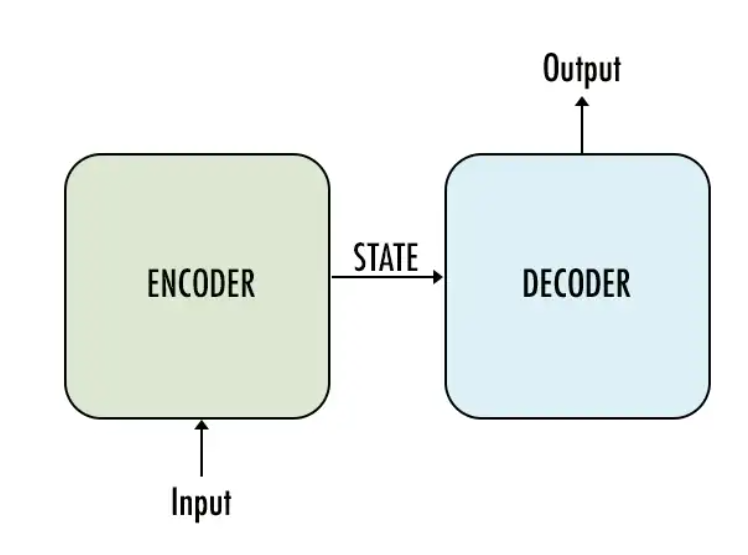

### Méthode 1



One way to do so est de:   

-  Convertir les labels de la colonne ICD-10 en séquences de lettre
-  Utiliser du padding pour gérer les séquences de longueur variable, et déterminer si les prédictions relatives au padding doivent être considérées dans la fonction objectif lors de l'ajustement du modèle.
- Déterminer si les métriques choisies doivent considérer le padding dans leur estimation.

Puis, on va définir deux fonctions : **make_encoder** et **make_decoder**.

#### Etapes de construction du Modèle

La fonction make_encoder crée un modèle de codage (encoder) en utilisant le framework de deep learning Keras.

  - Elle définit un input de type chaîne de caractères.
  - Ensuite, elle ajoute une couche de vectorisation de textes k.layers.TextVectorization, qui permet de transformer du texte en un format numérique utilisable par le réseau de neurones. 
  - La couche de vectorisation est adaptée à des données textuelles fournies (rawtext).
  - Ensuite, la sortie de la couche de vectorisation est entrée dans une couche d'incorporation k.layers.Embedding, qui convertit les vecteurs de nombres en un format compact et dense. Les dimensions d'entrée et de sortie sont définies par MAX_VOCAB et HIDDEN_DIM respectivement, et le masquage à zéro est activé.
  - Finalement, une couche RNN LSTM est ajoutée, avec HIDDEN_DIM unités, un taux de décroissance de 0,1 et avec un état de retour activé. Les sorties de la couche LSTM sont stockées dans states_h et states_c.
  - Enfin, le modèle est retourné avec l'input inputs et les outputs [states_h, states_c].

La fonction make_decoder crée un modèle de décodage (decoder) similairement à make_encoder.

  - Elle définit 3 inputs: target pour le texte cible, state_h pour l'état caché et state_c pour l'état de mémoire cellulaire.
  - La couche de vectorisation de textes est définie de la même manière que pour l'encoder
  - Ensuite, une couche d'incorporation de mots cibles est ajoutée, similaire à la couche d'incorporation de l'encoder.
  - Finalement, une couche LSTM similaire à celle de l'encoder est ajoutée, avec l'état initial défini par les inputs state_h et state_c. Les sorties de la couche LSTM sont les outputs du modèle.
  - Le modèle est retourné avec les inputs target, state_h et state_c et les outputs outputs.

In [ ]:
train=pd.read_csv('/content/train.csv')
val=pd.read_csv('/content/val.csv')
test=pd.read_csv('/content/test.csv')

In [ ]:
# Convertir un code ICD-10 en une séquence de caractères and ajout de START et END tokens
train['label']=train.ICD10.apply(list).str.join(' ')
val['label']=val.ICD10.apply(lambda x:list(x)).str.join(' ')
test['label']=test.ICD10.apply(lambda x:list(x)).str.join(' ')

## <START> and <stop> tokens

train.label= '<start>' + train.label + '<stop>'
val.label= '<start>' + val.label + '<stop>'
test.label= '<start>' + test.label + '<stop>'

In [ ]:
train.head()

,RawText,ICD10,label
0,Thrombose veineuse profonde cuisse gauche,I802,<start>I 8 0 2<stop>
1,Hémiplégie post-traumatique,S099,<start>S 0 9 9<stop>
2,Masculinisation avec hyperplasie surrénale,E250,<start>E 2 5 0<stop>
3,Hyperammoniémie cérébrale,E722,<start>E 7 2 2<stop>
4,Fistule artérioveineuse congénitale périphériq...,Q257,<start>Q 2 5 7<stop>


In [ ]:
# Prétraitement des données
def preprocess_data(sequences, max_length):
  sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=max_length)
  return sequences

# Construction de l'objet Dataset
def build_dataset(sequences, labels):
  dataset = tf.data.Dataset.from_tensor_slices((sequences, labels))
  dataset = dataset.shuffle(buffer_size=len(sequences))
  return dataset

Les métriques choisies ne doivent pas considérer le padding dans leur estimation car elles sont ajoutées simplement pour remplir les séquences et n'ont pas de signification réelle.

In [ ]:
def make_encoder():
  inputs = k.Input(shape=[], dtype=tf.string)
  source_vectorization_layer = k.layers.TextVectorization(max_tokens=MAX_VOCAB)
  source_vectorization_layer.adapt(train.RawText)
  outputs = source_vectorization_layer(inputs)
  outputs = k.layers.Embedding(
      input_dim=MAX_VOCAB,
      output_dim=HIDDEN_DIM,
      mask_zero=True
  )(outputs)
  encoder_rnn = k.layers.LSTM(
      units=HIDDEN_DIM,
      dropout=0.1,
      return_state=True
  )
  _, states_h, states_c = encoder_rnn(outputs)
  return k.Model(inputs=inputs, outputs=[states_h, states_c])

def make_decoder():
  target = k.Input(shape=[], dtype=tf.string)
  state_h = k.Input(shape=[HIDDEN_DIM])
  state_c = k.Input(shape=[HIDDEN_DIM])
  target_vectorization_layer = k.layers.TextVectorization(max_tokens=26 + 10 + 2)
  target_vectorization_layer.adapt(train.label)
  outputs = target_vectorization_layer(target)
  target_embedding = k.layers.Embedding(
      input_dim=26 + 10 + 2,
      output_dim=HIDDEN_DIM,
      mask_zero=True
  )
  outputs = target_embedding(outputs)
  decoder_rnn = k.layers.LSTM(
      units=HIDDEN_DIM,
      dropout=0.1,
      return_state=True
  )
  outputs, _, _ = decoder_rnn(outputs, initial_state=[state_h, state_c])
  return k.Model(inputs=[target, state_h, state_c], outputs=outputs)



**The padding influences the accuracy**

For handling the bad effect of padding, we can define new metrics. This new metric must ignore the class related to padding

In [ ]:
from keras import backend as K
 
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

In [ ]:
model = make_encoder()
decoder = make_decoder()

# Combiner les deux modèles en un seul modèle complet
inputs = k.Input(shape=[], dtype=tf.string)
encoder_states = model(inputs)
decoder_outputs = decoder([inputs] + encoder_states)

model_complete = k.Model(inputs, decoder_outputs)

# Compiler le modèle complet
model_complete.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', ignore_class_accuracy(0)] )

model_complete.save_weights("model_weights.h5")

# Entraîner le modèle
model_complete.fit(dataset, epochs=10, batch_size=64)


#### Prédiction Gloutonne à partir du modèle ajusté

**Principe**: la fonction de prédiction gloutonne fonctionne en utilisant le modèle ajusté pour prédire un caractère à la fois en concaténant le caractère précédemment prédit avec le token <START> pour former une nouvelle entrée au modèle. Cette étape est répétée jusqu'à ce que tous les caractères dans le code CIM correspondant soient prédits.

In [ ]:
def greedy_predict(model, fr_input, start_token, end_token):
  cim_code = [start_token]
  fr_input = [fr_input]
  while True:
    vectorized_cim = text_vectorization_layer.vectorize(cim_code)
    vectorized_fr = text_vectorization_layer.vectorize(fr_input)
    decoder_states = model.predict([vectorized_fr, vectorized_cim])
    decoder_output = model.predict([vectorized_fr, decoder_states[0], decoder_states[1]])
    next_char = text_vectorization_layer.unvectorize(decoder_output)[0]
    if next_char == end_token:
      break
    cim_code.append(next_char)
  return ''.join(cim_code[1:])


### Méthode 2 : Vanilla LSTM ( using sequence of characters ! )

Essayons une 2ème approche qui ressemble un peu à la première méthode, mais avec des changements surtout au niveau de l'ajustement du modèle.

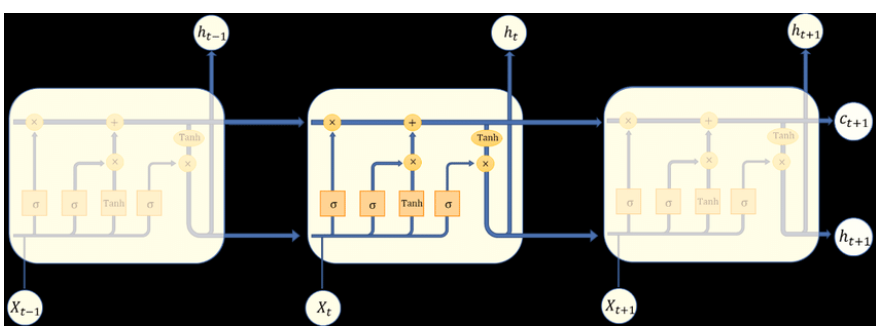

-> We will first create two sets for the input and target characters and then add characters to the sets as it loops through the data. The sets are then sorted and converted to lists. The number of unique input and output tokens (or characters) are calculated, as well as the maximum length of the input and target sequences. This information will be used to define the shape of the input and target data when it is fed into the model.

In [ ]:
train=pd.read_csv('/content/train.csv')
val=pd.read_csv('/content/val.csv')
test=pd.read_csv('/content/test.csv')

In [ ]:
# Convertir un code ICD-10 en une séquence de caractères and ajout de START et END tokens
train['label']=train.ICD10.apply(list).str.join(' ')
val['label']=val.ICD10.apply(lambda x:list(x)).str.join(' ')
test['label']=test.ICD10.apply(lambda x:list(x)).str.join(' ')

In [ ]:
# Setting random values for now. Will notify if these values change
max_encoder_seq_length = 75
max_decoder_seq_length = 65

In [ ]:
# Vectorize the data.
input_characters = set()
target_characters = set()

for i in range(0, len(train.RawText)):
    # Start == '\s'
    # End == '\e'
    train.ICD10[i] = "\s" + train.label[i] + "\e"

    for char in train.RawText[i]:
        if char not in input_characters:
            input_characters.add(char)
    for char in train.ICD10[i]:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_X_len = max([len(txt) for txt in train.RawText])
max_y_len = max([len(txt) for txt in train.ICD10])

print("Number of samples:", len(train.RawText))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)

if max_X_len > max_encoder_seq_length:
    print("WARNING: NEW Max sequence length for inputs:", max_X_len)
    print("Dataset may be incompatible with older models.")
    max_encoder_seq_length = max_X_len

if max_y_len > max_decoder_seq_length:
    print("WARNING: NEW Max sequence length for outputs:", max_y_len)
    print("Dataset may be incompatible with older models.")
    max_decoder_seq_length = max_y_len

print(target_characters)

Number of samples: 181763
Number of unique input tokens: 102
Number of unique output tokens: 40
Dataset may be incompatible with older models.
[' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '\\', 'e', 's']


The code above is initializing three arrays to store the data in a numerical format:

    encoder_input_data: 3D array of shape (number of samples, max_encoder_seq_length, num_encoder_tokens), which stores the input sequence.
    decoder_input_data: 3D array of shape (number of samples, max_decoder_seq_length, num_decoder_tokens), which stores the input sequence for the decoder.
    decoder_target_data: 3D array of shape (number of samples, max_decoder_seq_length, num_decoder_tokens), which stores the target sequence for the decoder.

The arrays are initialized as zero arrays of type float32.

The variable input_token_index is a dictionary that maps each character in the input text to an integer, and target_token_index is similar, but maps characters in the target sequence to integers.

In [ ]:
# char to index
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(train.RawText), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(train.RawText), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(train.RawText), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

Now, let's prepare the input data for the encoder and decoder in a sequence-to-sequence model. It loops through the input text and target text in the training set, and uses the input_token_index and target_token_index dictionaries to map the characters to their corresponding indices. Then, it uses these indices to populate the encoder_input_data, decoder_input_data, and decoder_target_data arrays.

The encoder_input_data array is a 3-dimensional array of shape (len(train.RawText), max_encoder_seq_length, num_encoder_tokens) that holds the one-hot encoded representations of the input texts in the training set.

The decoder_input_data and decoder_target_data arrays are similarly 3-dimensional arrays of shape (len(train.RawText), max_decoder_seq_length, num_decoder_tokens) that hold the one-hot encoded representations of the target texts in the training set, where the decoder_target_data is shifted by one time step relative to the decoder_input_data.

At the end, the code prints the first example in the encoder_input_data array, for demonstration purposes.

In [ ]:
import sys

np.set_printoptions(threshold=10)

for i, (input_text, target_text) in enumerate(zip(train.RawText, train.ICD10)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

encoder_input_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Finally ! Let's build our Seq2Seq model

In [ ]:
latent_dim = 256
batch_size = 64  # Batch size for training.
epochs = 10  # Number of epochs to train for.
simple_name = "lstm"

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(
    latent_dim, recurrent_dropout=0.1, return_state=True, name="encoder"
)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(
    latent_dim,
    recurrent_dropout=0.1,
    return_sequences=True,
    return_state=True,
    name="decoder",
)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_pred = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)

full_model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
import datetime


early_stop = EarlyStopping(patience=2, monitor="val_loss", mode="min", verbose=1)

# Start Training
history = full_model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop],
)

Epoch 1/3
2557/2557 [==============================] - 4096s 2s/step - loss: 0.0652 - accuracy: 0.9787 - val_loss: 0.0584 - val_accuracy: 0.9802
Epoch 2/3
2557/2557 [==============================] - 4144s 2s/step - loss: 0.0563 - accuracy: 0.9812 - val_loss: 0.0554 - val_accuracy: 0.9816
Epoch 3/3
2557/2557 [==============================] - 4115s 2s/step - loss: 0.0524 - accuracy: 0.9827 - val_loss: 0.0504 - val_accuracy: 0.9834


**Note :** 

- Simple RNN: All neural networks are trained through a variant of gradient descent, which is an iterative process with the intent of minimizing gradient descent at the end of the iteration. One of the challenges with the simple RNN is that the gradient in this neural network is not stable. Early gradients are a product of later gradients, they tend to increase or decrease dramatically. This is described as the exploding gradient problem.
- LSTM: LSTMs introduce the concept of cell states, which provide “highways” for the gradient to flow backward through time freely, thereby making it more resistant to the vanishing gradient problem. The cell state can be thought of almost like data stored in a computer’s memory. LSTMs can “remember” or “forget” information in the cell state by using specialized neurons called “gates”. This way, LSTMs can retain long-term dependencies and connect information from the past to the present.

### Methode 3: GRU ( using sequence of characters )

The key difference between a GRU and an LSTM is that a GRU has two gates (reset and update gates) whereas an LSTM has three gates (namely input, output and forget gates).

Why do we make use of GRU when we clearly have more control on the network through the LSTM model (as we have three gates)? In which scenario GRU is preferred over LSTM?  

**Answer =>** GRUs and LSTMs utilize different approaches toward gating information to prevent the vanishing gradient problem. Here are the main points comparing the two:

- The GRU unit controls the flow of information like the LSTM unit, but without having to use a memory unit. It just exposes the full hidden content without any control.
- GRUs are relatively new, their performance is on par with LSTMs, but computationally more efficient (they have a less complex structure). For that reason,it's being used more and more.


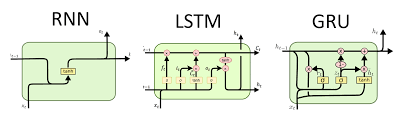

In [ ]:
latent_dim = 96
batch_size = 64  # Batch size for training.
epochs = 3  # Number of epochs to train for.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = GRU(latent_dim, recurrent_dropout=0.333, return_state=True, name="encoder")
encoder_outputs, encoder_state = encoder(encoder_inputs)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_gru = GRU(
    latent_dim,
    recurrent_dropout=0.2,
    return_sequences=True,
    return_state=True,
    name="decoder",
)
decoder_outputs, _ = decoder_gru(decoder_inputs, initial_state=encoder_state)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_pred = decoder_dense(decoder_outputs)

early_stop = EarlyStopping(patience=3, monitor="val_loss")

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)

full_model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
early_stop = EarlyStopping(patience=2, monitor="val_loss", mode="min", verbose=1)

# Start Training
history = full_model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop],
)

Epoch 1/3
2557/2557 [==============================] - 985s 383ms/step - loss: 0.0738 - accuracy: 0.9785 - val_loss: 0.0584 - val_accuracy: 0.9800
Epoch 2/3
2557/2557 [==============================] - 968s 379ms/step - loss: 0.0575 - accuracy: 0.9807 - val_loss: 0.0569 - val_accuracy: 0.9809
Epoch 3/3
2557/2557 [==============================] - 968s 379ms/step - loss: 0.0565 - accuracy: 0.9811 - val_loss: 0.0559 - val_accuracy: 0.9815
